# TODO
* Evaluer erreurs
* Voir les associations mots->classe
* Voir les ech. qui activent certaines classes
* Éviter les cas d'overlap! (Val 85  Test 190)

In [30]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, BatchNormalization, Input
from keras.layers.merge import Add
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.optimizers import SGD

from sklearn.metrics import classification_report

import classif

%matplotlib inline
plt.rcParams['image.cmap'] = 'jet'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
data, num_classes, gen, gen_dual, dual_data = classif.load_data()

count_size = data['X_train'][1].shape[1]

q_labels = ['Démocratie: Comment reprendre le pouvoir?',
'Économie: Comment développer le Québec selon nos priorités?',
'Régions: Comment dynamiser toutes nos communautés?',
'Indépendance: Comment se remettre en marche?',
'Éducation: Comment permettre à tout le monde de réaliser son plein potentiel?',
'Premiers Peuples: Comment construire la solidarité entre nous?',
'Diversité: Comment vivre ensemble sans racisme ni discrimination?',
'Culture: Comment favoriser une création artistique vivante et en assurer l’accès à tous?',
'Santé: Comment prendre soin de tout le monde?',
'Climat: Comment enclencher la transition?']

short_labels = ['Démocratie',
'Économie',
'Régions',
'Indépendance',
'Éducation',
'Premiers Peuples',
'Diversité',
'Culture',
'Santé',
'Climat']

N train, val, test: 3172 317 1799


In [54]:
def build_model(num_classes, l2_reg):
    model = Sequential()
    model.add(BatchNormalization(input_shape=(64,), gamma_regularizer=l2(l2_reg)))
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization(gamma_regularizer=l2(l2_reg)))
    model.add(Dense(1024, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization(gamma_regularizer=l2(l2_reg)))
    model.add(Dense(1024, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization(gamma_regularizer=l2(l2_reg)))
    model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_reg)))
    
    model.compile('adam', 'categorical_crossentropy', metrics=['acc'])
    return model

def build_model_dual(num_classes, count_size, lr, l2_reg):
    embed_in = Input(shape=(64,))
    count_in = Input(shape=(count_size,))
    count_embed = Dense(64)(count_in)
    reembed = Add()([embed_in, count_embed])
    x = BatchNormalization(gamma_regularizer=l2(l2_reg))(reembed)
    x = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization(gamma_regularizer=l2(l2_reg))(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization(gamma_regularizer=l2(l2_reg))(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    codes = BatchNormalization(gamma_regularizer=l2(l2_reg))(x)
    x = Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_reg), name='preds')(codes)
    model = Model([embed_in, count_in], [x, codes])
    optimizer = SGD(lr=lr)  # TODO set decay
    model.compile(optimizer, ['categorical_crossentropy', None], metrics=['acc'])
    return model

In [32]:
# Perform grid search
# best l2_reg = 0.01
from itertools import product as itprod
lr_list = 2. ** np.array([-6, -5, -4, -3])
reg_list = [1e-6, 1e-5, 1e-4]
#results = {}

for lr, reg in itprod(lr_list, reg_list):
    print('Trying: lr {}  reg {}'.format(lr, reg))
    model = build_model_dual(num_classes, count_size, lr=lr, l2_reg=reg)
    history = classif.train(model, data, gen_dual, verbose=0, epochs=30)
    val_acc = np.max(history.history['val_acc'])
    print('Val acc: ' + str(val_acc))
    results[lr, reg] = val_acc

Trying: lr 0.015625  reg 1e-06
Training...
Val acc: 0.968454260743
Trying: lr 0.015625  reg 1e-05
Training...
Val acc: 0.962145112478
Trying: lr 0.015625  reg 0.0001
Training...
Val acc: 0.971608834876
Trying: lr 0.03125  reg 1e-06
Training...
Val acc: 0.965299686611
Trying: lr 0.03125  reg 1e-05
Training...
Val acc: 0.981072557273
Trying: lr 0.03125  reg 0.0001
Training...
Val acc: 0.96529968285
Trying: lr 0.0625  reg 1e-06
Training...
Val acc: 0.971608834876
Trying: lr 0.0625  reg 1e-05
Training...
Val acc: 0.949526812564
Trying: lr 0.0625  reg 0.0001
Training...
Val acc: 0.95268138632
Trying: lr 0.125  reg 1e-06
Training...
Val acc: 0.933753941901
Trying: lr 0.125  reg 1e-05
Training...
Val acc: 0.955835962521
Trying: lr 0.125  reg 0.0001
Training...
Val acc: 0.952681386696


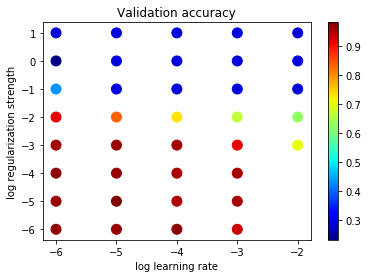

In [33]:
# Visualize the cross-validation results
import math
x_scatter = [np.log2(x[0]) for x in results]
y_scatter = [np.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x] for x in results]
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('Validation accuracy')
plt.show()

In [59]:
# Train best model
model = build_model_dual(num_classes, count_size=count_size, lr=2**-4, l2_reg=0)
history = classif.train(model, data, gen_dual, epochs=100)

Training...
Epoch 1/100
100/100 [==============================] - 6s - loss: 2.2476 - preds_loss: 2.2476 - preds_acc: 0.4309 - val_loss: 1.8387 - val_preds_loss: 1.8387 - val_preds_acc: 0.4353
Epoch 2/100
100/100 [==============================] - 1s - loss: 1.3773 - preds_loss: 1.3773 - preds_acc: 0.5962 - val_loss: 1.4548 - val_preds_loss: 1.4548 - val_preds_acc: 0.5142
Epoch 3/100
100/100 [==============================] - 1s - loss: 1.1722 - preds_loss: 1.1722 - preds_acc: 0.6428 - val_loss: 1.2862 - val_preds_loss: 1.2862 - val_preds_acc: 0.5615
Epoch 4/100
100/100 [==============================] - 1s - loss: 1.0183 - preds_loss: 1.0183 - preds_acc: 0.6966 - val_loss: 1.1573 - val_preds_loss: 1.1573 - val_preds_acc: 0.6498
Epoch 5/100
100/100 [==============================] - 1s - loss: 0.8486 - preds_loss: 0.8486 - preds_acc: 0.7434 - val_loss: 1.1201 - val_preds_loss: 1.1201 - val_preds_acc: 0.6498
Epoch 6/100
100/100 [==============================] - 1s - loss: 0.7642 - pre

100/100 [==============================] - 1s - loss: 0.0849 - preds_loss: 0.0849 - preds_acc: 0.9700 - val_loss: 0.0671 - val_preds_loss: 0.0671 - val_preds_acc: 0.9779
Epoch 46/100
100/100 [==============================] - 1s - loss: 0.0789 - preds_loss: 0.0789 - preds_acc: 0.9756 - val_loss: 0.0572 - val_preds_loss: 0.0572 - val_preds_acc: 0.9874
Epoch 47/100
100/100 [==============================] - 1s - loss: 0.1076 - preds_loss: 0.1076 - preds_acc: 0.9625 - val_loss: 0.0648 - val_preds_loss: 0.0648 - val_preds_acc: 0.9779
Epoch 48/100
100/100 [==============================] - 1s - loss: 0.0986 - preds_loss: 0.0986 - preds_acc: 0.9712 - val_loss: 0.0466 - val_preds_loss: 0.0466 - val_preds_acc: 0.9811
Epoch 49/100
100/100 [==============================] - 1s - loss: 0.0768 - preds_loss: 0.0768 - preds_acc: 0.9744 - val_loss: 0.0477 - val_preds_loss: 0.0477 - val_preds_acc: 0.9811
Epoch 50/100
100/100 [==============================] - 1s - loss: 0.0860 - preds_loss: 0.0860 - p

KeyboardInterrupt: 

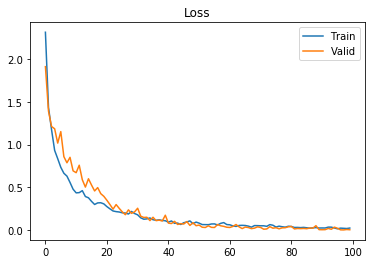

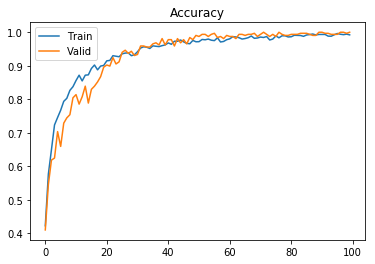

In [55]:
plt.figure()
plt.title('Loss')
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Valid')
plt.legend()
plt.show()
plt.figure()
plt.title('Accuracy')
plt.plot(history.history['dense_285_acc'], label='Train')
plt.plot(history.history['val_dense_285_acc'], label='Valid')
plt.legend()
plt.show()

In [56]:
y_pred, vectors = model.predict(data['X_test'])
y_pred = to_categorical(np.argmax(y_pred, axis=1), num_classes)
test_acc = np.mean(y_pred == data['y_test'])
print('Test accuracy: ' + str(test_acc))
print(classification_report(data['y_test'], y_pred))
print(vectors.shape)

Test accuracy: 0.999555308505
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       440
          1       1.00      1.00      1.00        91
          2       1.00      1.00      1.00       239
          3       1.00      1.00      1.00        21
          4       1.00      1.00      1.00       492
          5       1.00      1.00      1.00        44
          6       1.00      1.00      1.00         7
          7       1.00      1.00      1.00        45
          8       1.00      1.00      1.00        97
          9       0.99      1.00      0.99       323

avg / total       1.00      1.00      1.00      1799

(1799, 1024)


In [57]:
_, vectors = model.predict(dual_data)
print(vectors.shape)

(5288, 1024)


In [58]:
np.savetxt('fqsp_embed.tsv', vectors, delimiter='\t')

In [92]:
import word2vec
import matplotlib.pyplot as plt
embedder = word2vec.Embedder()

Embedding answers...


In [337]:
def plot_pred(y_pred):
    ind = np.arange(num_classes)  # the x locations for the groups
    width = 0.35                  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, y_pred.ravel() * 100)

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Probabilité')
    ax.set_title('Sujet')
    ax.set_xticks(ind)
    ax.set_xticklabels(short_labels, rotation=70)
    ax.set_ylim([0.,100.])

    plt.show()

Mots inconnus. Somme: 0.0


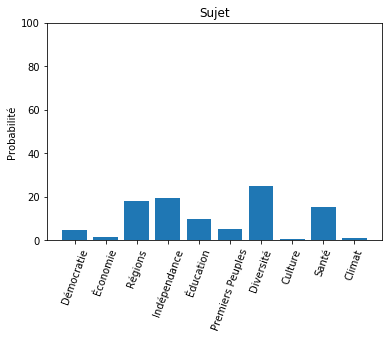

In [344]:
test_ans = embedder.embed_phrase("civic")
somme = np.sum(np.abs(test_ans))
if somme < 1e-3:
    print('Mots inconnus. Somme: ' + str(somme))
y_pred = model.predict(test_ans[None, :])
plot_pred(y_pred)